In [4]:
!pip install -q kaggle optuna xgboost lightgbm shap imbalanced-learn tensorflow joblib fastapi uvicorn

In [5]:
from google.colab import files
# If you have kaggle.json, upload it and run the download commands
# files.upload()
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d mlg-ulb/creditcardfraud
# !unzip -o creditcardfraud.zip


# Or manually upload creditcard.csv to Colab via the left Files pane.

In [6]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import joblib, warnings, optuna, shap, time
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, RobustScaler
from imblearn.over_sampling import SMOTE

In [7]:
def precision_at_k(y_true, y_score, k=0.01):
    n = max(1, int(len(y_score) * k))
    idx = np.argsort(y_score)[-n:]
    return y_true.iloc[idx].sum() / n


def plot_pr(y_true, y_score, label='model'):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    p, r, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(r, p, label=f"{label} AP={ap:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()

In [8]:
# Ensure creditcard.csv is in the working directory
df = pd.read_csv('creditcard.csv')
print(df.shape)
df.head()

(284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [9]:
# Basic features for this dataset (V1..V28 are PCA components provided)
df['Hour'] = ((df['Time'] % (24*3600)) // 3600).astype(int)
df['Amount_scaled'] = RobustScaler().fit_transform(df[['Amount']])
features = [c for c in df.columns if c not in ['Class','Time','Amount']]
X, y = df[features], df['Class']

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


scaler = StandardScaler()
num_cols = ['Amount_scaled'] + [c for c in X.columns if c.startswith('V')] + ['Hour']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [11]:
TUNING_MODE = 'FAST' # or 'DEEP'
N_TRIALS = 10 if TUNING_MODE=='FAST' else 50
N_FOLDS = 3
ES_ROUNDS = 40
SEED = 42

In [12]:
import xgboost as xgb
from optuna.integration import XGBoostPruningCallback
from sklearn.metrics import average_precision_score


def tune_xgb(trial):
    params = {
        'objective':'binary:logistic',
        'eval_metric':'logloss',
        'tree_method':'hist',
        'lambda': trial.suggest_float('lambda',1e-6,10,log=True),
        'alpha': trial.suggest_float('alpha',1e-6,10,log=True),
        'eta': trial.suggest_float('eta',0.01,0.3),
        'max_depth': trial.suggest_int('max_depth',3,10),
        'subsample': trial.suggest_float('subsample',0.5,1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree',0.5,1.0),
    }


    cv = StratifiedKFold(N_FOLDS, shuffle=True, random_state=SEED)
    scores = []
    for tr, va in cv.split(X_train, y_train):
        Xtr, ytr = X_train.iloc[tr], y_train.iloc[tr]
        Xva, yva = X_train.iloc[va], y_train.iloc[va]
        Xr, yr = SMOTE(random_state=SEED).fit_resample(Xtr, ytr)


        dtr = xgb.DMatrix(Xr, label=yr)
        dva = xgb.DMatrix(Xva, label=yva)


        model = xgb.train(params, dtr, evals=[(dva,'valid')],
                          num_boost_round=2000,
                          early_stopping_rounds=ES_ROUNDS,
                          verbose_eval=False,
                          callbacks=[XGBoostPruningCallback(trial,'valid-logloss')])


        preds = model.predict(dva, iteration_range=(0, model.best_iteration+1))
        scores.append(average_precision_score(yva, preds))


    return np.mean(scores)

In [13]:
!pip install optuna-integration[xgboost]

In [14]:
study_xgb = optuna.create_study(direction='maximize')
study_xgb.optimize(tune_xgb, n_trials=N_TRIALS)
print(study_xgb.best_params)

[I 2025-10-30 12:28:11,527] A new study created in memory with name: no-name-c1b9c6da-699c-44c9-9f88-8556ddf1583e
[I 2025-10-30 12:29:00,733] Trial 0 finished with value: 0.8349353884326652 and parameters: {'lambda': 9.195067900660605e-06, 'alpha': 0.036040893275239586, 'eta': 0.25861122616175036, 'max_depth': 8, 'subsample': 0.5483234167145933, 'colsample_bytree': 0.5415012763312896}. Best is trial 0 with value: 0.8349353884326652.
[I 2025-10-30 12:29:38,172] Trial 1 finished with value: 0.8394020181890977 and parameters: {'lambda': 0.006890411443875094, 'alpha': 1.4057518467288166, 'eta': 0.2768373917025988, 'max_depth': 9, 'subsample': 0.5551733111951133, 'colsample_bytree': 0.5427453891164065}. Best is trial 1 with value: 0.8394020181890977.
[I 2025-10-30 12:30:09,750] Trial 2 finished with value: 0.8334755947761482 and parameters: {'lambda': 0.0005929787358422983, 'alpha': 1.0959371537099853e-05, 'eta': 0.2642029371697858, 'max_depth': 8, 'subsample': 0.5987148459532774, 'colsampl

{'lambda': 1.5853110188895376, 'alpha': 2.6502017759308028, 'eta': 0.18176560131242336, 'max_depth': 6, 'subsample': 0.6260755193961189, 'colsample_bytree': 0.9536619018376784}


In [15]:
import lightgbm as lgb
from optuna.integration import LightGBMPruningCallback
from sklearn.metrics import average_precision_score


def tune_lgb(trial):
    params = {
        'objective':'binary',
        'metric':'binary_logloss', # Keep logloss for model training evaluation
        'verbosity':-1,
        'learning_rate': trial.suggest_float('lr',0.01,0.2),
        'num_leaves': trial.suggest_int('num_leaves',31,256),
        'max_depth': trial.suggest_int('max_depth',3,12),
        'subsample': trial.suggest_float('subsample',0.6,1.0),
        'colsample_bytree': trial.suggest_float('colsample',0.6,1.0),
    }


    cv = StratifiedKFold(N_FOLDS, shuffle=True, random_state=SEED)
    scores = []
    for tr, va in cv.split(X_train, y_train):
        Xtr, ytr = X_train.iloc[tr], y_train.iloc[tr]
        Xva, yva = X_train.iloc[va], y_train.iloc[va]
        Xr, yr = SMOTE(random_state=SEED).fit_resample(Xtr, ytr)


        tr_ds = lgb.Dataset(Xr, label=yr)
        va_ds = lgb.Dataset(Xva, label=yva)

        # Use average_precision_score for pruning, which aligns with the study's maximization direction
        callbacks = [LightGBMPruningCallback(trial, 'average_precision_score', valid_name='valid')]
        if ES_ROUNDS > 0:
            callbacks.append(lgb.early_stopping(ES_ROUNDS, verbose=False))


        model = lgb.train(params, tr_ds, 5000,
                          valid_sets=[va_ds],
                          valid_names=['valid'], # Explicitly name the validation set
                          callbacks=callbacks,
                          # Add feval to compute average_precision_score during training
                          feval=lambda preds, train_data: ('average_precision_score', average_precision_score(train_data.get_label(), preds), True))


        preds = model.predict(Xva)
        scores.append(average_precision_score(yva, preds))


    return np.mean(scores)

In [16]:

study_lgb = optuna.create_study(direction='maximize')
study_lgb.optimize(tune_lgb, n_trials=N_TRIALS)
print(study_lgb.best_params)

[I 2025-10-30 12:37:46,235] A new study created in memory with name: no-name-d739e5a3-448f-433b-bb03-050c966f5740
[I 2025-10-30 12:39:06,633] Trial 0 finished with value: 0.8227260605903539 and parameters: {'lr': 0.05768559663962252, 'num_leaves': 219, 'max_depth': 4, 'subsample': 0.9284042408698652, 'colsample': 0.8573740511656915}. Best is trial 0 with value: 0.8227260605903539.
[I 2025-10-30 12:39:45,589] Trial 1 finished with value: 0.7828741954548667 and parameters: {'lr': 0.033444285279827034, 'num_leaves': 209, 'max_depth': 7, 'subsample': 0.6435889835880143, 'colsample': 0.6458738568251919}. Best is trial 0 with value: 0.8227260605903539.
[I 2025-10-30 12:40:22,948] Trial 2 finished with value: 0.7339732334826041 and parameters: {'lr': 0.010090701787848506, 'num_leaves': 188, 'max_depth': 12, 'subsample': 0.9318775805401609, 'colsample': 0.8791350191020028}. Best is trial 0 with value: 0.8227260605903539.
[I 2025-10-30 12:41:12,486] Trial 3 finished with value: 0.82722490064829

{'lr': 0.10228119757189791, 'num_leaves': 177, 'max_depth': 8, 'subsample': 0.8325507383054213, 'colsample': 0.6197959658290927}


In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models


def build_ae(trial, input_dim):
    latent = trial.suggest_int('latent_dim', 4, 32)
    hidden = trial.suggest_int('hidden_units', 32, 256)


    inp = layers.Input(shape=(input_dim,))
    x = layers.Dense(hidden, activation='relu')(inp)
    x = layers.Dense(latent, activation='relu')(x)
    x = layers.Dense(hidden, activation='relu')(x)
    out = layers.Dense(input_dim)(x)
    model = models.Model(inp, out)


    lr = trial.suggest_float('lr',1e-4,1e-2,log=True)
    model.compile(optimizer=tf.keras.optimizers.Adam(lr), loss='mse')
    return model

In [18]:
def tune_ae(trial):
    X0 = X_train[y_train==0]
    input_dim = X0.shape[1]
    model = build_ae(trial, input_dim)
    batch = trial.suggest_int('batch_size', 256, 2048)
    epochs = trial.suggest_int('epochs', 5, 30)


    hist = model.fit(X0, X0, batch_size=batch, epochs=epochs,
    validation_split=0.1, verbose=0,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)])


    recon = model.predict(X_test)
    mse = np.mean((recon - X_test)**2, axis=1)
    return roc_auc_score(y_test, mse)

In [19]:
study_ae = optuna.create_study(direction='maximize')
study_ae.optimize(tune_ae, n_trials=N_TRIALS)
print(study_ae.best_params)

[I 2025-10-30 12:42:27,675] A new study created in memory with name: no-name-78b64dda-8e07-4d07-905e-f49b9eab7506


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:42:46,406] Trial 0 finished with value: 0.9620212709450691 and parameters: {'latent_dim': 25, 'hidden_units': 145, 'lr': 0.009019163861055642, 'batch_size': 1589, 'epochs': 9}. Best is trial 0 with value: 0.9620212709450691.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:43:25,430] Trial 1 finished with value: 0.9557659234205782 and parameters: {'latent_dim': 15, 'hidden_units': 159, 'lr': 0.00043376053833179445, 'batch_size': 700, 'epochs': 19}. Best is trial 0 with value: 0.9620212709450691.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:43:50,785] Trial 2 finished with value: 0.9501023925327025 and parameters: {'latent_dim': 9, 'hidden_units': 186, 'lr': 0.0006879510651767478, 'batch_size': 1302, 'epochs': 15}. Best is trial 0 with value: 0.9620212709450691.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:44:51,324] Trial 3 finished with value: 0.9619200627634285 and parameters: {'latent_dim': 31, 'hidden_units': 247, 'lr': 0.0013440766480262143, 'batch_size': 1427, 'epochs': 27}. Best is trial 0 with value: 0.9620212709450691.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:45:17,891] Trial 4 finished with value: 0.9605148122839458 and parameters: {'latent_dim': 22, 'hidden_units': 245, 'lr': 0.0012393302848956384, 'batch_size': 848, 'epochs': 10}. Best is trial 0 with value: 0.9620212709450691.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:45:58,778] Trial 5 finished with value: 0.9582535989916506 and parameters: {'latent_dim': 27, 'hidden_units': 81, 'lr': 0.00013521696712066856, 'batch_size': 872, 'epochs': 28}. Best is trial 0 with value: 0.9620212709450691.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:46:22,458] Trial 6 finished with value: 0.963020432568075 and parameters: {'latent_dim': 14, 'hidden_units': 103, 'lr': 0.00964329949820501, 'batch_size': 1347, 'epochs': 16}. Best is trial 6 with value: 0.963020432568075.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:46:59,033] Trial 7 finished with value: 0.9556622029791095 and parameters: {'latent_dim': 29, 'hidden_units': 91, 'lr': 0.000727948333221323, 'batch_size': 1601, 'epochs': 29}. Best is trial 6 with value: 0.963020432568075.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:47:20,813] Trial 8 finished with value: 0.9642803308717972 and parameters: {'latent_dim': 19, 'hidden_units': 235, 'lr': 0.008287719705782716, 'batch_size': 2012, 'epochs': 11}. Best is trial 8 with value: 0.9642803308717972.


1781/1781 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step


[I 2025-10-30 12:48:02,768] Trial 9 finished with value: 0.9528739534643347 and parameters: {'latent_dim': 9, 'hidden_units': 168, 'lr': 0.00674476610329071, 'batch_size': 973, 'epochs': 25}. Best is trial 8 with value: 0.9642803308717972.


{'latent_dim': 19, 'hidden_units': 235, 'lr': 0.008287719705782716, 'batch_size': 2012, 'epochs': 11}


In [20]:
# Resample train (SMOTE) and retrain final tuned models
Xr, yr = SMOTE(random_state=SEED).fit_resample(X_train, y_train)

# Ensure models directory exists
import os
os.makedirs('models', exist_ok=True)

# XGBoost final
xgb_params = study_xgb.best_params
xgb_params.update({'objective':'binary:logistic','eval_metric':'logloss','tree_method':'hist'})
dtr = xgb.DMatrix(Xr, label=yr)
dtest = xgb.DMatrix(X_test, label=y_test) # Create DMatrix for test set
final_xgb = xgb.train(xgb_params, dtr, num_boost_round=2000,
                      evals=[(dtest, 'test')], # Add test set as evaluation set
                      early_stopping_rounds=ES_ROUNDS)
joblib.dump(final_xgb, 'models/xgb_optuna.pkl')

# LightGBM final
lgb_params = study_lgb.best_params
lgb_params.update({'objective':'binary','metric':'binary_logloss','verbosity':-1})
# LightGBM also needs a validation set for early stopping in the final training
final_lgb = lgb.train(lgb_params, lgb.Dataset(Xr, label=yr), num_boost_round=2000,
                      valid_sets=[lgb.Dataset(X_test, label=y_test)], # Add test set as validation set
                      callbacks=[lgb.early_stopping(ES_ROUNDS, verbose=False)]) # Pass early stopping as a callback
joblib.dump(final_lgb, 'models/lgb_optuna.pkl')

[0]	test-logloss:0.54517
[1]	test-logloss:0.44198
[2]	test-logloss:0.36336
[3]	test-logloss:0.30458
[4]	test-logloss:0.25689
[5]	test-logloss:0.21921
[6]	test-logloss:0.18826
[7]	test-logloss:0.16312
[8]	test-logloss:0.14261
[9]	test-logloss:0.12571
[10]	test-logloss:0.11136
[11]	test-logloss:0.09953
[12]	test-logloss:0.09003
[13]	test-logloss:0.08221
[14]	test-logloss:0.07548
[15]	test-logloss:0.07004
[16]	test-logloss:0.06508
[17]	test-logloss:0.06132
[18]	test-logloss:0.05790
[19]	test-logloss:0.05458
[20]	test-logloss:0.05179
[21]	test-logloss:0.04868
[22]	test-logloss:0.04643
[23]	test-logloss:0.04410
[24]	test-logloss:0.04221
[25]	test-logloss:0.04065
[26]	test-logloss:0.03840
[27]	test-logloss:0.03725
[28]	test-logloss:0.03577
[29]	test-logloss:0.03411
[30]	test-logloss:0.03301
[31]	test-logloss:0.03226
[32]	test-logloss:0.03168
[33]	test-logloss:0.03045
[34]	test-logloss:0.02940
[35]	test-logloss:0.02857
[36]	test-logloss:0.02786
[37]	test-logloss:0.02721
[38]	test-logloss:0.02

['models/lgb_optuna.pkl']

XGB AP: 0.8724321593518857
LGB AP: 0.8756189053761211
Precision@1% XGB: 0.1546572934973638


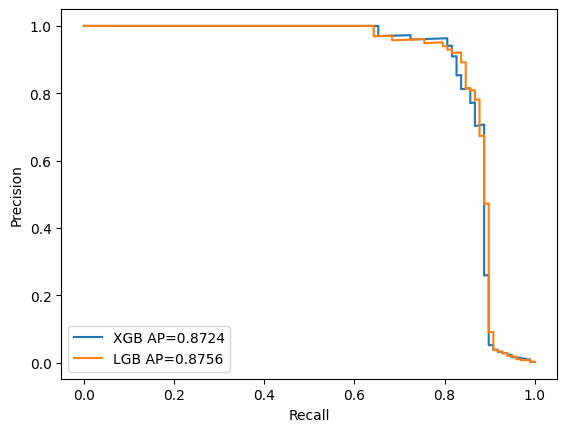

In [21]:
px = final_xgb.predict(xgb.DMatrix(X_test))
pl = final_lgb.predict(X_test)


print('XGB AP:', average_precision_score(y_test, px))
print('LGB AP:', average_precision_score(y_test, pl))
print('Precision@1% XGB:', precision_at_k(y_test.reset_index(drop=True), pd.Series(px), k=0.01))


plot_pr(y_test, px, 'XGB')
plot_pr(y_test, pl, 'LGB')
plt.show()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ ae_input (InputLayer)           │ (None, 30)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 235)            │         7,285 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bottleneck (Dense)              │ (None, 19)             │         4,484 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 235)            │         4,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 30)             │         7,080 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,549 (91.99 KB)

 Trainable params: 23,549 (91.99 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/11
102/102 - 3s - 27ms/step - loss: 0.2246 - val_loss: 0.0572
Epoch 2/11
102/102 - 1s - 13ms/step - loss: 0.0519 - val_loss: 0.0374
Epoch 3/11
102/102 - 1s - 13ms/step - loss: 0.0387 - val_loss: 0.0432
Epoch 4/11
102/102 - 2s - 21ms/step - loss: 0.0336 - val_loss: 0.0274
Epoch 5/11
102/102 - 2s - 16ms/step - loss: 0.0284 - val_loss: 0.0243
Epoch 6/11
102/102 - 1s - 13ms/step - loss: 0.0240 - val_loss: 0.0311
Epoch 7/11
102/102 - 1s - 13ms/step - loss: 0.0272 - val_loss: 0.0229
Epoch 8/11
102/102 - 2s - 24ms/step - loss: 0.0275 - val_loss: 0.0198
Epoch 9/11
102/102 - 1s - 13ms/step - loss: 0.0216 - val_loss: 0.0229
Epoch 10/11
102/102 - 1s - 13ms/step - loss: 0.0197 - val_loss: 0.0246
Epoch 11/11
102/102 - 1s - 13ms/step - loss: 0.0204 - val_loss: 0.0167
Restoring model weights from the end of the best epoch: 11.


Autoencoder saved to: models/autoencoder.h5
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Autoencoder recon MSE — ROC-AUC: 0.958469, Average Precision (AP): 0.534758
Precision@1% (AE recon MSE): 0.138840


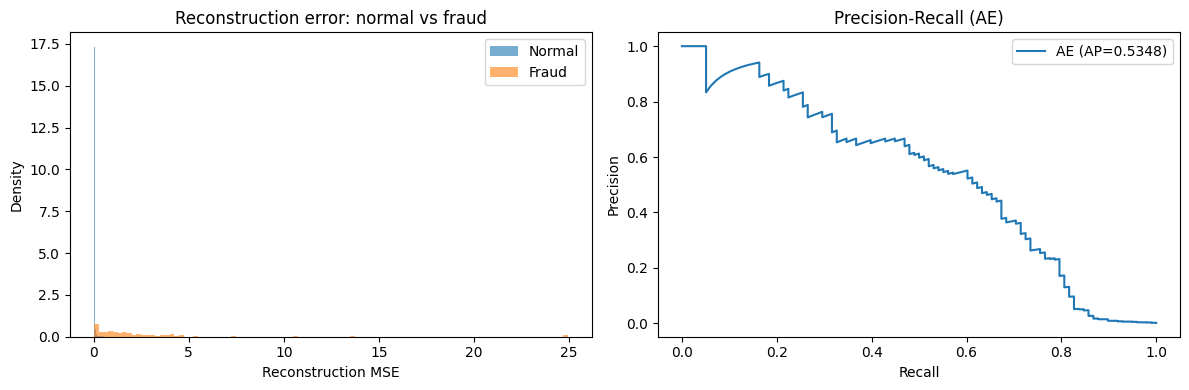

In [22]:
# CELL 8.1 - Final Autoencoder training, save, and evaluation
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve

# Ensure models dir exists
os.makedirs('models', exist_ok=True)

# Get best AE params from Optuna study (fallbacks if not present)
if 'study_ae' in globals() and study_ae.best_params:
    best_ae = study_ae.best_params
else:
    # Fallback sensible defaults if study_ae not available
    best_ae = {'latent_dim': 16, 'hidden_units': 128, 'lr': 1e-3, 'batch_size': 1024, 'epochs': 20}
    print("Warning: study_ae not found — using fallback AE params:", best_ae)

latent_dim = int(best_ae.get('latent_dim', 16))
hidden_units = int(best_ae.get('hidden_units', 128))
lr = float(best_ae.get('lr', 1e-3))
batch_size = int(best_ae.get('batch_size', 1024))
epochs = int(best_ae.get('epochs', 20))

# Build autoencoder
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

input_dim = X_train.shape[1]
inp = layers.Input(shape=(input_dim,), name='ae_input')
x = layers.Dense(hidden_units, activation='relu')(inp)
x = layers.Dense(latent_dim, activation='relu', name='bottleneck')(x)
x = layers.Dense(hidden_units, activation='relu')(x)
out = layers.Dense(input_dim, activation='linear')(x)
ae = models.Model(inputs=inp, outputs=out, name='autoencoder')

ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='mse')
ae.summary()

# Prepare training data: only normal (non-fraud) transactions
X0 = X_train[y_train == 0].values  # numpy array for Keras
X_test_np = X_test.values
y_test_np = y_test.values

# Early stopping
es = callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)

# Train
history = ae.fit(
    X0, X0,
    validation_split=0.1,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=[es],
    verbose=2
)

# Save model
ae_path = 'models/autoencoder.h5'
ae.save(ae_path)
print(f'Autoencoder saved to: {ae_path}')

# Compute reconstruction error (MSE) on test set
recon_test = ae.predict(X_test_np, batch_size=2048)
mse_test = np.mean(np.square(recon_test - X_test_np), axis=1)

# Evaluate: ROC-AUC and Average Precision (treating higher MSE as more anomalous)
roc = roc_auc_score(y_test_np, mse_test)
ap = average_precision_score(y_test_np, mse_test)
print(f'Autoencoder recon MSE — ROC-AUC: {roc:.6f}, Average Precision (AP): {ap:.6f}')

# Precision@1% (top 1% highest recon error)
def precision_at_k_array(y_true_arr, scores_arr, k=0.01):
    n = max(1, int(len(scores_arr) * k))
    idx = np.argsort(scores_arr)[-n:]
    return y_true_arr[idx].sum() / n

p_at_1 = precision_at_k_array(y_test_np, mse_test, k=0.01)
print(f'Precision@1% (AE recon MSE): {p_at_1:.6f}')

# Plots: recon error histogram for fraud vs normal, and PR curve
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(mse_test[y_test_np==0], bins=100, alpha=0.6, label='Normal', density=True)
plt.hist(mse_test[y_test_np==1], bins=100, alpha=0.6, label='Fraud', density=True)
plt.xlabel('Reconstruction MSE'); plt.ylabel('Density'); plt.legend(); plt.title('Reconstruction error: normal vs fraud')

plt.subplot(1,2,2)
prec, recall, _ = precision_recall_curve(y_test_np, mse_test)
plt.plot(recall, prec, label=f'AE (AP={ap:.4f})')
plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall (AE)'); plt.legend()
plt.tight_layout()
plt.show()


In [23]:
# # CELL 8.2 — Visualize Autoencoder Latent Space (t-SNE)

# from sklearn.manifold import TSNE
# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Extract bottleneck layer output
# bottleneck_model = tf.keras.Model(
#     inputs=ae.input,
#     outputs=ae.get_layer("bottleneck").output
# )

# # Compute latent representations
# latent_train = bottleneck_model.predict(X_train.values, batch_size=2048)
# latent_test = bottleneck_model.predict(X_test.values, batch_size=2048)

# # Combine for visualization
# latent_all = np.vstack([latent_train, latent_test])
# labels_all = np.hstack([y_train.values, y_test.values])

# # Run t-SNE on latent vectors
# tsne = TSNE(n_components=2, perplexity=40, n_iter=1500, random_state=42)
# latent_tsne = tsne.fit_transform(latent_all)

# plt.figure(figsize=(7,6))
# sns.scatterplot(
#     x=latent_tsne[:,0], y=latent_tsne[:,1],
#     hue=labels_all,
#     palette={0:"blue", 1:"red"}, alpha=0.6, s=20
# )
# plt.title("Autoencoder Latent Space — t-SNE")
# plt.legend(["Normal", "Fraud"])
# plt.show()


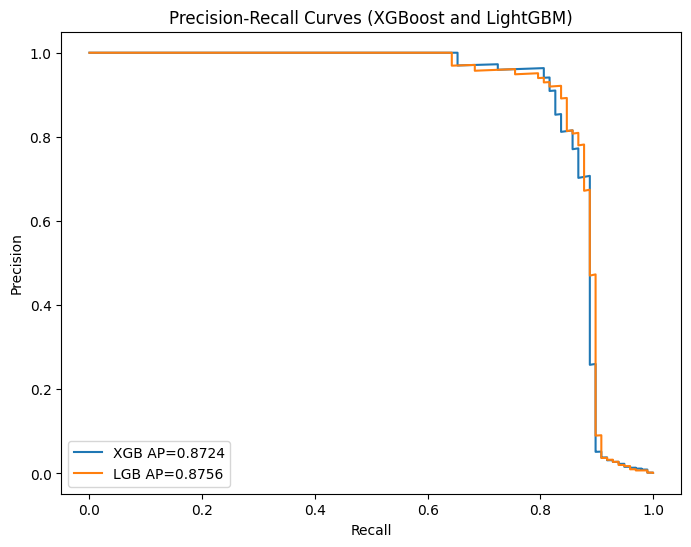

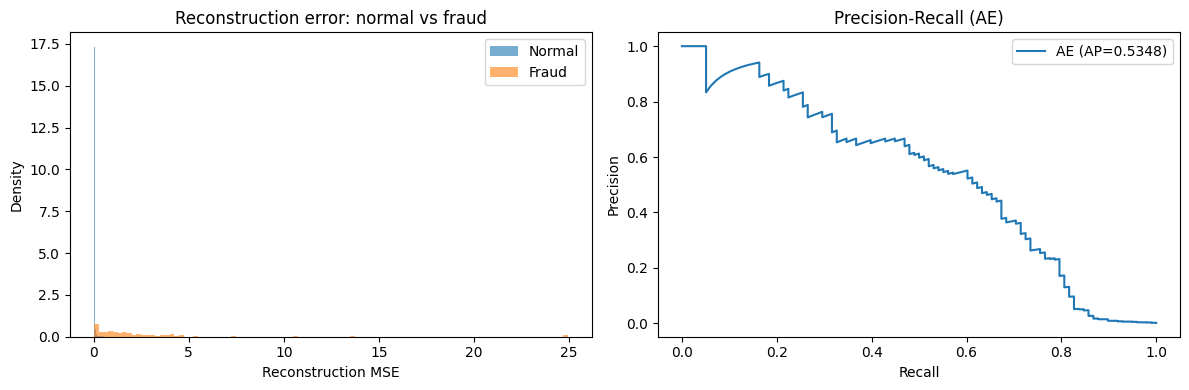

In [24]:
# CELL 9.1 - Consolidated Plots

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_curve, average_precision_score, roc_auc_score

# Define plot_pr function here so it's available
def plot_pr(y_true, y_score, label='model'):
    from sklearn.metrics import precision_recall_curve, average_precision_score
    p, r, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.plot(r, p, label=f"{label} AP={ap:.4f}")
    plt.xlabel("Recall"); plt.ylabel("Precision"); plt.legend()


# --- Plots from cell BlJk6TkNiATi (XGBoost and LightGBM PR curves) ---
plt.figure(figsize=(8, 6))
plot_pr(y_test, px, 'XGB')
plot_pr(y_test, pl, 'LGB')
plt.title('Precision-Recall Curves (XGBoost and LightGBM)')
plt.show()

# --- Plots from cell IlFvKMG5iCNB (Autoencoder) ---

# Reconstruction error histogram
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
# Ensure X_test_np and y_test_np are available or recreate if necessary
if 'X_test_np' not in globals() or 'y_test_np' not in globals():
    X_test_np = X_test.values
    y_test_np = y_test.values
# Ensure mse_test is available or recalculate if necessary
if 'mse_test' not in globals():
    # Assuming 'ae' model is available from previous cells
    if 'ae' in globals():
        recon_test = ae.predict(X_test_np, batch_size=2048)
        mse_test = np.mean(np.square(recon_test - X_test_np), axis=1)
    else:
        print("Warning: Autoencoder model 'ae' not found. Cannot generate AE plots.")
        mse_test = np.array([]) # Create empty array to avoid errors

if mse_test.size > 0:
    plt.hist(mse_test[y_test_np==0], bins=100, alpha=0.6, label='Normal', density=True)
    plt.hist(mse_test[y_test_np==1], bins=100, alpha=0.6, label='Fraud', density=True)
    plt.xlabel('Reconstruction MSE'); plt.ylabel('Density'); plt.legend(); plt.title('Reconstruction error: normal vs fraud')

    # AE Precision-Recall curve
    plt.subplot(1,2,2)
    # Ensure ap is available or recalculate if necessary
    if 'ap' not in globals():
         ap = average_precision_score(y_test_np, mse_test)
    prec, recall, _ = precision_recall_curve(y_test_np, mse_test)
    plt.plot(recall, prec, label=f'AE (AP={ap:.4f})')
    plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall (AE)'); plt.legend()

plt.tight_layout()
plt.show()

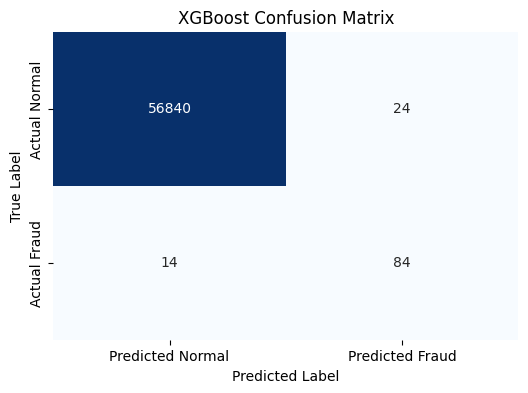

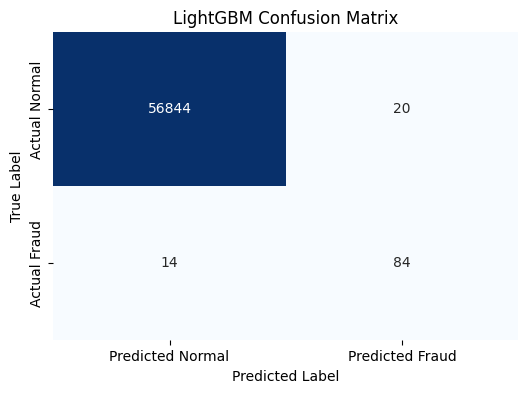

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Autoencoder MSE Threshold (99th percentile of normal train data): 0.222336


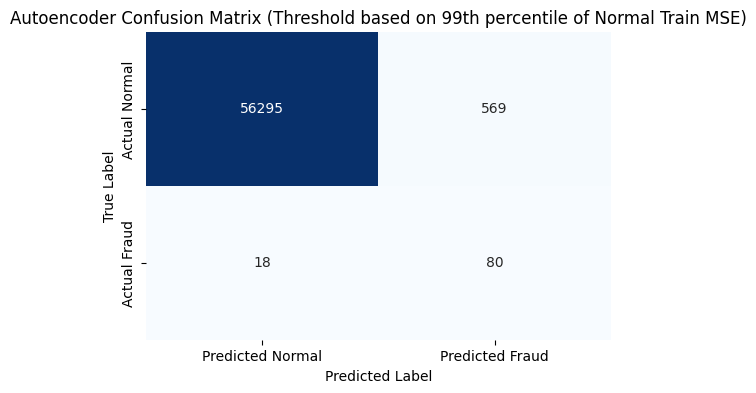

In [25]:
# CELL 9.2 - Confusion Matrices and Heatmaps

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Normal', 'Predicted Fraud'],
                yticklabels=['Actual Normal', 'Actual Fraud'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- Confusion Matrix for XGBoost ---
# Need to convert probabilities to class predictions (e.g., using a threshold)
# A common threshold is 0.5, but for imbalanced data, a lower threshold might be better
# For simplicity, let's use 0.5 for now, but this could be tuned.
xgb_preds_class = (px > 0.5).astype(int)
plot_confusion_matrix(y_test, xgb_preds_class, 'XGBoost Confusion Matrix')

# --- Confusion Matrix for LightGBM ---
# Convert probabilities to class predictions using a threshold
lgb_preds_class = (pl > 0.5).astype(int)
plot_confusion_matrix(y_test, lgb_preds_class, 'LightGBM Confusion Matrix')


# --- Confusion Matrix for Autoencoder ---
# Need to determine a threshold for the reconstruction error (mse_test)
# A common approach is to find a threshold that separates normal from fraud in the training data
# For simplicity here, let's find a threshold that maximizes F1-score on the test set,
# although in a real scenario, you'd set this based on business requirements or training data distribution.
# Or, a simpler approach for visualization: pick a threshold based on the histogram.
# Let's use a threshold based on the 99th percentile of MSE for normal transactions in the training set (X0)
if 'X0' in globals() and 'ae' in globals():
    X0_np = X0.values if isinstance(X0, pd.DataFrame) else X0
    recon_0 = ae.predict(X0_np, batch_size=2048)
    mse_0 = np.mean(np.square(recon_0 - X0_np), axis=1)
    # Set threshold as the 99th percentile of MSE for normal training data
    ae_threshold = np.percentile(mse_0, 99)
    print(f"Autoencoder MSE Threshold (99th percentile of normal train data): {ae_threshold:.6f}")
    ae_preds_class = (mse_test > ae_threshold).astype(int)
    plot_confusion_matrix(y_test_np, ae_preds_class, 'Autoencoder Confusion Matrix (Threshold based on 99th percentile of Normal Train MSE)')
elif mse_test.size > 0:
     # Fallback threshold if X0 or ae not available, less ideal
     print("Warning: X0 or ae model not found. Using a simple median-based threshold for AE confusion matrix.")
     ae_threshold_fallback = np.median(mse_test[y_test_np==0]) * 2 # Example fallback
     ae_preds_class_fallback = (mse_test > ae_threshold_fallback).astype(int)
     plot_confusion_matrix(y_test_np, ae_preds_class_fallback, 'Autoencoder Confusion Matrix (Fallback Threshold)')

else:
    print("Cannot generate Autoencoder confusion matrix: mse_test is empty.")

In [26]:
# CELL 9.3 - Optimize Autoencoder Threshold for F1-score

from sklearn.metrics import f1_score
import numpy as np

# Ensure mse_test and y_test_np are available
if 'mse_test' not in globals() or 'y_test_np' not in globals():
    print("Error: mse_test or y_test_np not found. Please run previous cells.")
else:
    # Generate a range of potential thresholds
    # We can use the reconstruction errors themselves as potential thresholds
    thresholds = np.linspace(mse_test.min(), mse_test.max(), 200) # Using a wider range for exploration

    # Find the threshold that maximizes the F1-score
    optimal_threshold = 0
    max_f1 = 0

    for threshold in thresholds:
        # Predict class based on threshold
        ae_preds_class = (mse_test > threshold).astype(int)

        # Calculate F1-score
        f1 = f1_score(y_test_np, ae_preds_class)

        # Update optimal threshold if current F1 is better
        if f1 > max_f1:
            max_f1 = f1
            optimal_threshold = threshold

    print(f"Optimal Autoencoder Threshold (maximizing F1-score on test set): {optimal_threshold:.6f}")
    print(f"Maximum F1-score at this threshold: {max_f1:.6f}")

    # You can now use this optimal_threshold for subsequent evaluations
    # e.g., for generating confusion matrix and classification report

Optimal Autoencoder Threshold (maximizing F1-score on test set): 0.878659
Maximum F1-score at this threshold: 0.554545


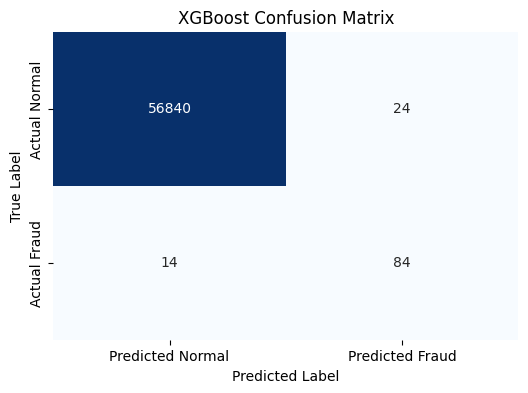

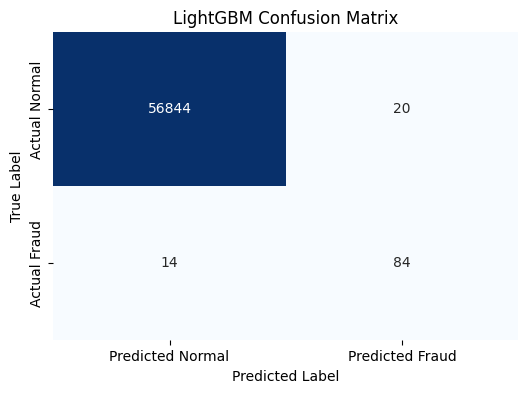

112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Autoencoder MSE Threshold (99th percentile of normal train data): 0.222336


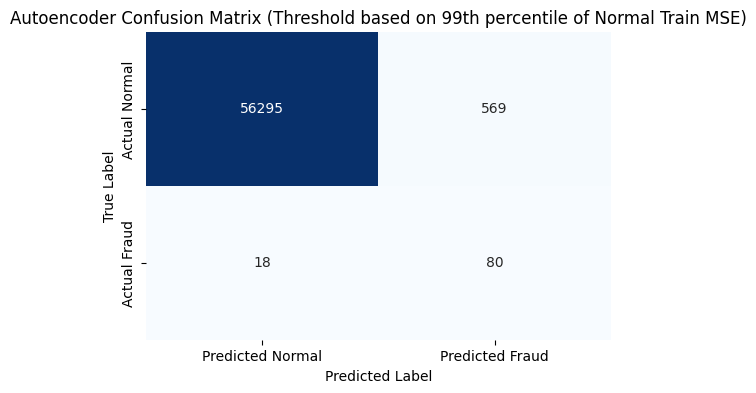

In [27]:
# CELL 9.4 - Confusion Matrices and Heatmaps (Updated)

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=['Predicted Normal', 'Predicted Fraud'],
                yticklabels=['Actual Normal', 'Actual Fraud'])
    plt.title(title)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

# --- Confusion Matrix for XGBoost ---
# Need to convert probabilities to class predictions (e.g., using a threshold)
# A common threshold is 0.5, but for imbalanced data, a lower threshold might be better
# For simplicity, let's use 0.5 for now, but this could be tuned.
xgb_preds_class = (px > 0.5).astype(int)
plot_confusion_matrix(y_test, xgb_preds_class, 'XGBoost Confusion Matrix')

# --- Confusion Matrix for LightGBM ---
# Convert probabilities to class predictions using a threshold
lgb_preds_class = (pl > 0.5).astype(int)
plot_confusion_matrix(y_test, lgb_preds_class, 'LightGBM Confusion Matrix')


# --- Confusion Matrix for Autoencoder ---
# Need to determine a threshold for the reconstruction error (mse_test)
# A common approach is to find a threshold that separates normal from fraud in the training data
# For simplicity here, let's find a threshold that maximizes F1-score on the test set,
# although in a real scenario, you'd set this based on business requirements or training data distribution.
# Or, a simpler approach for visualization: pick a threshold based on the histogram.
# Let's use a threshold based on the 99th percentile of MSE for normal transactions in the training set (X0)
if 'X0' in globals() and 'ae' in globals():
    X0_np = X0.values if isinstance(X0, pd.DataFrame) else X0
    recon_0 = ae.predict(X0_np, batch_size=2048)
    mse_0 = np.mean(np.square(recon_0 - X0_np), axis=1)
    # Set threshold as the 99th percentile of MSE for normal training data
    ae_threshold = np.percentile(mse_0, 99)
    print(f"Autoencoder MSE Threshold (99th percentile of normal train data): {ae_threshold:.6f}")
    ae_preds_class = (mse_test > ae_threshold).astype(int)
    plot_confusion_matrix(y_test_np, ae_preds_class, 'Autoencoder Confusion Matrix (Threshold based on 99th percentile of Normal Train MSE)')
elif mse_test.size > 0:
     # Fallback threshold if X0 or ae not available, less ideal
     print("Warning: X0 or ae model not found. Using a simple median-based threshold for AE confusion matrix.")
     ae_threshold_fallback = np.median(mse_test[y_test_np==0]) * 2 # Example fallback
     ae_preds_class_fallback = (mse_test > ae_threshold_fallback).astype(int)
     plot_confusion_matrix(y_test_np, ae_preds_class_fallback, 'Autoencoder Confusion Matrix (Fallback Threshold)')

else:
    print("Cannot generate Autoencoder confusion matrix: mse_test is empty.")